# SynthMorph PyTorch Demo

## Purpose
Reproduce the original SynthMorph demo in Torch.
- Data generation
- Registration model training
- Registration (inference) examples  

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from pathlib import Path
import urllib
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np 
import torch
import torch.multiprocessing as mp
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import pytorch_lightning as pl

# local code
from synthmorph import models, layers, losses, datamodule as dm, utils


In [4]:
with torch.no_grad():
    torch.cuda.empty_cache()
device = 'cuda' if torch.cuda.is_available() else 'cpu'     # note: only gpu has been tested so far
mp.set_start_method('spawn')

## SynthMorph Generation Demo

### Generate Label (i.e. Segmentation) Map

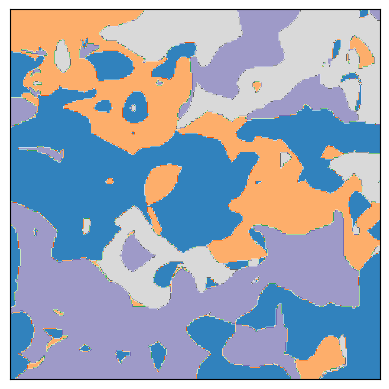

In [9]:
# Input shapes.
in_shape = (256,) * 2
num_dim = len(in_shape)
num_label = 4
label_map = dm.generate_map(in_shape, num_label, device=device)
label_map_viz = label_map.tolist() if device == "cuda" else label_map.numpy()

plt.imshow(label_map_viz, cmap='tab20c')
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.show()

### Generate Image from Label Map

100%|██████████| 16/16 [00:01<00:00,  8.36it/s]


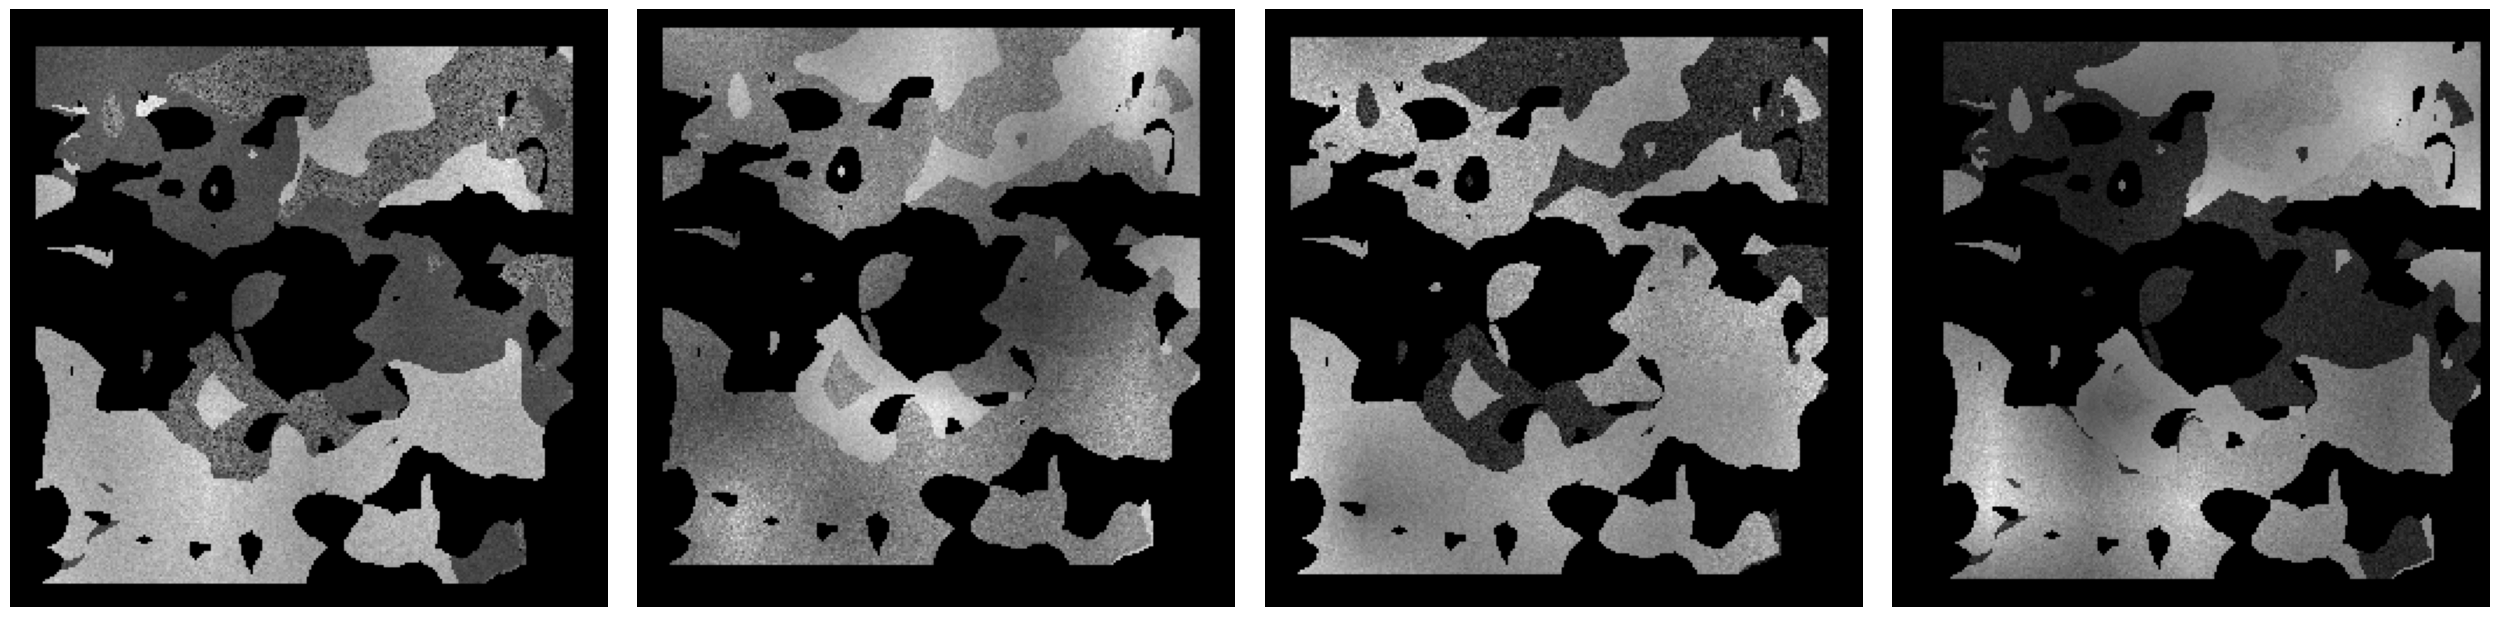

In [11]:
n = 16
affine_args = dict(
    translate=(0.05, 0.05),
    scale=(0.9, 0.9)
)
gen_args = dict(
    warp_std=0,
    warp_res=(8, 16, 32),
    zero_background=1,
    affine_args=affine_args,
)

gen = [dm.labels_to_image(label_map, **gen_args) for _ in tqdm(range(n))]
gen_images = [g['image'] for g in gen]
gen_labels= [g['label'] for g in gen]

plot_num = min(n, 4)
fig, axes = plt.subplots(1, plot_num, figsize=(plot_num*8, 8))

for i in range(plot_num):
    image = gen_images[i].squeeze().tolist()
    axes[i].imshow(image, cmap='gray')
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.05)
plt.show()


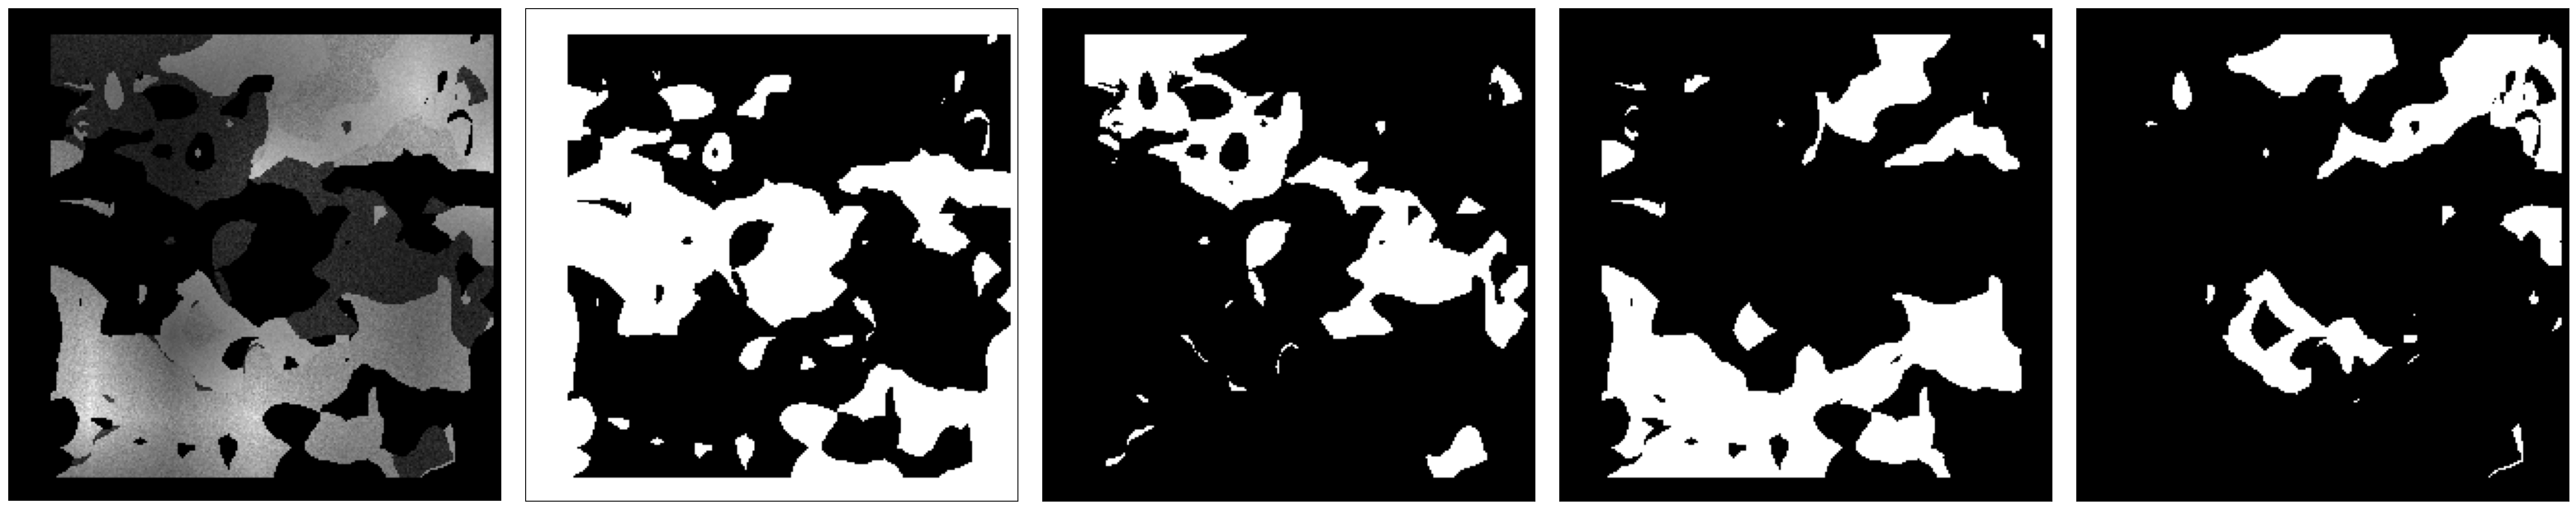

In [12]:
# Plot each label of an image
ind = 3
image = gen_images[ind].squeeze().tolist()
labels = gen_labels[ind].squeeze().tolist()
plot_num = gen_labels[ind].shape[0] + 1
fig, axes = plt.subplots(1, plot_num, figsize=(plot_num*8, 8))
axes[0].imshow(image, cmap='gray')
axes[0].axis('off')
for c in range(1, plot_num):
    ax = axes[c]
    l = labels[c - 1]
    ax.imshow(l, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

plt.subplots_adjust(wspace=0.05)
plt.show()

## Model Training

In [ ]:
size=40
in_shape = (256,) * 2
num_labels = 16
affine_args = dict(
    translate=(0.05, 0.05),
    scale=(0.9, 0.9)
)
gen_args = dict(
    warp_std=0,
    warp_res=(8, 16, 32),
    zero_background=1,
    affine_args=affine_args,
)

train_data = dm.SynthMorphDataset(
    size=size,
    input_size=in_shape,
    num_labels=num_labels,
    gen_args=gen_args,
)
dataloader_kwargs = {'num_workers': 8, 'persistent_workers': True,} if device == 'cuda' else {}
dataloader = DataLoader(
    dataset=train_data,
    batch_size=1,
    shuffle=True,
    **dataloader_kwargs
)

In [ ]:
# You can generate the Torch version of the original author's weights from tf2torch.ipynb
# State dict weights for the registration model, different from PL checkpoint
weights_path = Path(".") / 'weights'
# reg_weights = weights_path / 'torch' / "authors.pth"   # 'None' for no weight loading
reg_weights = None
# Fresh model
in_shape = (256,) * 2
unet_enc_nf = [256] * 4
unet_dec_nf = [256] * 8
model = models.SynthMorph(
    vol_size=in_shape,
    num_labels=train_data.num_labels,
    enc_nf=unet_enc_nf,
    dec_nf=unet_dec_nf,
    int_steps=7,
    int_resolution=2, 
    lmd=1,
    lr=1e-05,
    reg_weights=reg_weights,
)
n_param = utils.torch_model_parameters(model.reg_model)

In [ ]:
# # Model from checkpoint
# checkpoint_path = './lightning_logs/version_standard/checkpoints/epoch=9999-step=400k.ckpt'
# model = models.SynthMorph.load_from_checkpoint(
#     checkpoint_path,
#     lr=1e-05,
# )

In [ ]:
max_epochs = 2500
steps = train_data.size
max_steps = max_epochs * steps
trainer = pl.Trainer(
    accelerator='gpu',
    max_epochs=max_epochs,
    max_steps=max_steps,
    log_every_n_steps=steps
)


In [ ]:
trainer.fit(model=model, train_dataloaders=dataloader)

In [ ]:
# Save registration model weights only
save_reg_weights = weights_path / 'torch' / "translation_simple.pth"
# model.save_weigths(save_reg_weights)

## Model  Evaluation

In [ ]:
in_shape = (256,) * 2
unet_enc_nf = [256] * 4
unet_dec_nf = [256] * 8
num_labels = 16
# Model from weights
weights_path = Path(".") / 'weights'
reg_weights = weights_path / 'torch' / "translation_simple.pth"
model = models.SynthMorph(
    vol_size=in_shape,
    num_labels=num_labels,
    enc_nf=unet_enc_nf,
    dec_nf=unet_dec_nf,
    int_steps=0,     # no diffeo
    int_resolution=1, # no diffeo
    lmd=1,
    reg_weights=reg_weights
)
model = model.to(device)

In [ ]:
# Model from checkpoint
# checkpoint_path = './lightning_logs/version_46/checkpoints/epoch=9999-step=400k.ckpt'
# model = models.SynthMorph.load_from_checkpoint(checkpoint_path,)

In [ ]:
model = model.eval()

### SynthMorph Images

In [ ]:
size= 40
in_shape = (256,) * 2
num_labels = 16
gen_args = dict(
    warp_std=0,
    warp_res=(8, 16, 32),
    zero_background=1,
    affine_args= {
        'translate': 0.05,
    },
)

test_data = dm.SynthMorphDataset(
    size=size,
    input_size=in_shape,
    num_labels=num_labels,
    gen_args=gen_args,
)
dataloader_kwargs = {'num_workers': 8, 'persistent_workers': True, } if device == 'cuda' else {}
test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=1,
    shuffle=False,
    **dataloader_kwargs
)

In [ ]:
# Evaluate dice score
eval_size = int(1e3)
dice_arr = np.zeros(shape=(eval_size,))
for i in tqdm(range(eval_size)):
    gen = next(iter(test_dataloader))
    moving = gen['moving']
    fixed = gen['fixed']
    moving_map = gen['moving_map']
    fixed_map = gen['fixed_map']
    _, warp = model.predict_step(moving, fixed) 
    moved_map = layers.SpatialTransformer(fill_value=0)([moving_map, warp])
    dice = -losses.Dice().loss(fixed_map, moved_map)
    dice_arr[i] = dice.tolist()
dice_arr.mean()

In [ ]:
# Plot example registration
gen = next(iter(test_dataloader))
moving = gen['moving']
fixed = gen['fixed']
moved, warp = model.predict_step(moving, fixed)
moved_np, warp_np = dm.torch2numpy(moved), dm.torch2numpy(warp)
moving_np, fixed_np = dm.torch2numpy(moving), dm.torch2numpy(fixed)

In [ ]:
movement_plot = [moving_np, fixed_np, moved_np]
movement_headers = ['Moving', 'Fixed', 'Moved']
utils.plot_array_row(movement_plot, movement_headers, cmap='gray')

In [ ]:
warp_plot = [warp_np[0, ...], warp_np[1, ...]]
warp_headers=['Warp X-Axis', 'Warp Y-Axis']
utils.plot_array_row(warp_plot, warp_headers, cmap='gray')

### MNIST

In [ ]:
mnist = MNIST(root= "./data", train=False, download=True)

In [ ]:
images = np.array(mnist.data)
labels = np.array(mnist.targets)
indices = np.arange(len(labels))
# Dictionary of indices based on target labels
label_indices_dict = {}
unique_labels = np.unique(labels)
for label in unique_labels:
    label_indices_dict[label] = np.where(labels == label)[0].tolist()

In [ ]:
# Example prediction
in_shape = (256,) * 2
digit = 0
indices = label_indices_dict[digit]
ori_moving = images[indices[233]]
ori_fixed = images[indices[342]]
moving = dm.conform(x=ori_moving, in_shape=in_shape, device=device)
fixed = dm.conform(x=ori_fixed, in_shape=in_shape, device=device)
moved, warp = model.predict_step(moving, fixed)
moved, warp = dm.torch2numpy(moved), dm.torch2numpy(warp)
moving, fixed = moving.tolist(), fixed.tolist()
moving, fixed = np.squeeze(moving), np.squeeze(fixed)

In [ ]:
movement_plot = [moving, fixed, moved]
movement_headers = ['Moving', 'Fixed', 'Moved']
utils.plot_array_row(movement_plot, movement_headers, cmap='gray')

In [ ]:
warp_plot = [warp[0, ...], warp[1, ...]]
warp_headers=['Warp X-Axis', 'Warp Y-Axis']
utils.plot_array_row(warp_plot, warp_headers, cmap='gray')

### Oasis-1 2D (Brain dataset)

In [ ]:
oasis_path = Path.home() / "oasis_2d"
oasis_path.mkdir(exist_ok=True)
filename = oasis_path / '2D-OASIS-TUTORIAL.npz'
if not filename.exists():
    url = 'https://surfer.nmr.mgh.harvard.edu/pub/data/voxelmorph/2D-OASIS-TUTORIAL.npz'
    urllib.request.urlretrieve(url, filename)
oasis_data = np.load(filename)['images']


In [ ]:
in_shape = (256,) * 2
ori_moving = oasis_data[2]
ori_fixed = oasis_data[1]
moving = dm.conform(x=ori_moving, in_shape=in_shape, device=device)
fixed = dm.conform(x=ori_fixed, in_shape=in_shape, device=device)
moved, warp = model.predict_step(moving, fixed)
moved, warp = dm.torch2numpy(moved), dm.torch2numpy(warp)
moving, fixed = moving.detach().cpu().numpy(), fixed.detach().cpu().numpy()
moving, fixed = np.squeeze(moving), np.squeeze(fixed)

In [ ]:
movement_plot = [moving, fixed, moved]
movement_headers = ['Moving', 'Fixed', 'Moved']
utils.plot_array_row(movement_plot, movement_headers, cmap='gray')

In [ ]:
warp_plot = [warp[0, ...], warp[1, ...]]
warp_headers=['Warp X-Axis', 'Warp Y-Axis']
utils.plot_array_row(warp_plot, warp_headers, cmap='gray')

### Joint registration test
Evaluates registration for the following properties of target shapes:
- Size (scaling)
- Coordinates (translation, rotation)

#### Superimposed circles on synthetic image
Note: The label map is only used to create synthetic images which serve as background, only the circles are considered labels (i.e. target shapes)

In [ ]:
size= 1
in_shape = (256,) * 2
num_labels = 16
gen_args = dict(
    warp_std=0,
    warp_res=(8, 16, 32),
    zero_background=1,
    mean_max=200   # Prevent sharing too similar intensities as circles (e.g. 255)
)

test_data = dm.SynthMorphDataset(
    size=size,
    input_size=in_shape,
    num_labels=num_labels,
    gen_args=gen_args,
)
dataloader_kwargs = {'num_workers': 1, 'persistent_workers': True, } if device == 'cuda' else {}
test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=1,
    shuffle=False,
    **dataloader_kwargs
)

In [ ]:
# Image generation
gen = next(iter(test_dataloader))
ori_image = np.asarray(gen['fixed'].squeeze().tolist())
image = ori_image.copy()


In [ ]:
# Example of superimposing circles on image
pixel_value = 255
size_range = (0.030, 0.030)
dist_range = (70, 71)
rotate = 0
x_shift = 0
y_shift = 0
superimposed = utils.superimpose_circles(
    image, 
    pixel_value, 
    size_range, 
    dist_range, 
    rotate,
    x_shift,
    y_shift,
)

superimposed_array = [ori_image, superimposed]
superimposed_headers = ['Original', 'Superimposed']
utils.plot_array_row(superimposed_array, superimposed_headers, cmap='gray')

In [ ]:
# Create random image-mask pairs for moving and fixed

moving_superimpose = lambda moving: utils.superimpose_circles(
    moving, 
    pixel_value=255, 
    size_range=(0.030, 0.030), 
    dist_range=(70, 71), 
    rotate=0,
    x_shift=0,
    y_shift=0,
)
moving = moving_superimpose(dm.torch2numpy(gen['moving']))

fixed_superimpose = lambda fixed: utils.superimpose_circles(
    fixed, 
    pixel_value=255, 
    size_range=(0.030, 0.030), 
    dist_range=(70, 71), 
    rotate=0,
    x_shift=5,
    y_shift=0,
)
zeros = np.zeros(shape=(256, 256), dtype=np.float32)
fixed_mask = fixed_superimpose(zeros)
fixed = fixed_superimpose(dm.torch2numpy(gen['fixed']))

moving = moving_superimpose(zeros)
fixed = fixed_superimpose(zeros)

moving = dm.conform(x=moving, in_shape=in_shape, device=device)
fixed = dm.conform(x=fixed, in_shape=in_shape, device=device)

moved, warp = model.predict_step(moving, fixed)
moved, warp = dm.torch2numpy(moved), dm.torch2numpy(warp)
# post-process for plotting
moving, fixed = dm.torch2numpy(moving.squeeze()), dm.torch2numpy(fixed.squeeze())

In [ ]:
movement_plot = [moving, fixed, moved]
movement_headers = ['Moving', 'Fixed', 'Moved']
utils.plot_array_row(movement_plot, movement_headers, cmap='gray')

In [ ]:
# The labels here are supposed to be the circles only,
#  ignore areas which share the same value
rgb_fixed = utils.convert_to_single_rgb(fixed, 'red')
rgb_moving = utils.convert_to_single_rgb(moving, 'green')
rgb_moved = utils.convert_to_single_rgb(moved, 'blue')

overlay_before = utils.overlay_images(rgb_fixed, rgb_moving)
overlay_after = utils.overlay_images(rgb_fixed, rgb_moved)

overlay_plot = [overlay_before, overlay_after,]
overlay_headers = ['Fixed and Moving', 'Fixed and Moved']
utils.plot_array_row(overlay_plot, overlay_headers, cmap=None)

In [ ]:
warp_plot = [warp[0, ...], warp[1, ...]]
warp_headers=['Warp X-Axis', 'Warp Y-Axis']
utils.plot_array_row(warp_plot, warp_headers, cmap='gray')